# Fixed Income Examples
This example notebook illustrates some of the more sophisticated functionality of the package, especially related to fixed income securities and strategies. 
For fixed income strategies:

 - capital allocations are not necessary, and initial capital is not used
 - bankruptcy is disabled (as money can always be borrowed at some rate, potentially represented as another asset)
 - weights are based off notional_value rather than value. For fixed income securities, notional value is just the position. For non-fixed income securities (i.e. equities), it is the market value of the position.
 - strategy notional_value is always positive, equal to the sum of the magnitudes of the notional values of all its children
 - strategy price is computed from additive PNL returns per unit of notional_value, with a reference price of PAR
 - "rebalancing" the portfolio adjusts notionals rather than capital allocations based on weights
 
Further to the above characteristics of fixed income strategies, we also demonstrate the usage of the following features which arise in these types of use case:

 - Coupon paying securities (i.e. bonds)
 - Handing of security lifecycle such as new issues and maturity
 - Usage of "On-The-Run" instruments, and rolling of positions into the "new" on-the-run security at pre-defined times
 - Risk tracking/aggregation and hedging from pre-computed risk per unit notional

The notebook contains the following parts:

 0. **Setup**
 
 1. **Market data generation**
    1. Rolling series of government bonds
    2. Corporate bonds with spreads driven by a common factor
 
 
 2. **Example 1: Basic Strategies**
    1. Weigh all active corporate bond equally
    2. Add hedging of interest rates risk with the on-the-run government bond
 
 
 3. **Example 2: Nested Strategies**
    1. One strategy buys the top N bonds, by yield
    2. Another strategy sells the bottom N bonds, by yield
    3. Parent strategy gives 50% weight to each of the above
    4. Add hedges of remaining interest rates risk with the on-the-run government bond

## Setup

In [1]:
import bt
import pandas as pd
from pandas.tseries.frequencies import to_offset
import numpy as np
np.random.seed(1234)
%matplotlib inline

In [2]:
# (Approximate) Price to yield calcs, and pvbp, for later use. Note we use clean price here.
def price_to_yield( p, ttm, coupon ):
    return ( coupon + (100. - p)/ttm ) / ( ( 100. + p)/2. ) * 100
def yield_to_price( y, ttm, coupon ):
    return (coupon + 100/ttm - 0.5 * y) / ( y/200 + 1/ttm)
def pvbp( y, ttm, coupon ):
    return (yield_to_price( y + 0.01, ttm, coupon ) - yield_to_price( y, ttm, coupon ))

In [3]:
# Utility function to set data frame values to nan before the security has been issued or after it has matured
def censor( data, ref_data ):    
    for bond in data:
        data.loc[ (data.index > ref_data['mat_date'][bond]) | (data.index < ref_data['issue_date'][bond]), bond] = np.NaN
    return data.ffill(limit=1,axis=0) # Because bonds might mature during a gap in the index (i.e. on the weekend)    

In [4]:
# Backtesting timeline setup
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2022-01-01')
timeline = pd.date_range( start_date, end_date, freq='B')

## Market Data Generation

In [5]:
# Government Bonds: Create synthetic data for a single series of rolling government bonds

# Reference Data
roll_freq = 'Q'   
maturity = 10 
coupon = 2.0
roll_dates = pd.date_range( start_date, end_date+to_offset(roll_freq), freq=roll_freq) # Go one period beyond the end date to be safe
issue_dates = roll_dates - roll_dates.freq
mat_dates = issue_dates + pd.offsets.DateOffset(years=maturity)
series_name = 'govt_10Y'
names = pd.Series(mat_dates).apply( lambda x : 'govt_%s' % x.strftime('%Y_%m'))
# Build a time series of OTR
govt_otr = pd.DataFrame( [ [ name for name, roll_date in zip(names, roll_dates) if roll_date >=d ][0] for d in timeline ], 
                        index=timeline,
                        columns=[series_name])
# Create a data frame of reference data
govt_data = pd.DataFrame( {'mat_date':mat_dates, 'issue_date': issue_dates, 'roll_date':roll_dates}, index = names)
govt_data['coupon'] = coupon

# Create the "roll map"
govt_roll_map = govt_otr.copy()
govt_roll_map['target'] = govt_otr[series_name].shift(-1)
govt_roll_map = govt_roll_map[ govt_roll_map[series_name] != govt_roll_map['target']]
govt_roll_map['factor'] = 1.
govt_roll_map = govt_roll_map.reset_index().set_index(series_name).rename(columns={'index':'date'}).dropna()

# Market Data and Risk
govt_yield_initial = 2.0
govt_yield_vol = 1. 
govt_yield = pd.DataFrame( columns = govt_data.index, index=timeline )
govt_yield_ts = (govt_yield_initial + np.cumsum( np.random.normal( 0., govt_yield_vol/np.sqrt(252), len(timeline)))).reshape(-1,1)
govt_yield.loc[:,:] = govt_yield_ts

govt_mat = pd.DataFrame( columns = govt_data.index, index=timeline, data=pd.NA ).astype('datetime64')
govt_mat.loc[:,:] = govt_data['mat_date'].values.T
govt_ttm = (govt_mat - timeline.values.reshape(-1,1))/pd.Timedelta('1Y')
govt_coupon = pd.DataFrame( columns = govt_data.index, index=timeline )
govt_coupon.loc[:,:] = govt_data['coupon'].values.T
govt_accrued = govt_coupon.multiply( timeline.to_series().diff()/pd.Timedelta('1Y'), axis=0 )
govt_accrued.iloc[0] = 0

govt_price = yield_to_price( govt_yield, govt_ttm, govt_coupon )
govt_price[ govt_ttm <= 0 ] = 100.
govt_price = censor(govt_price, govt_data) 
govt_pvbp = pvbp( govt_yield, govt_ttm, govt_coupon)
govt_pvbp[ govt_ttm <= 0 ] = 0.
govt_pvbp = censor(govt_pvbp, govt_data)

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3397: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# Corporate Bonds: Create synthetic data for a universe of corporate bonds

# Reference Data
n_corp = 50    # Number of corporate bonds to generate
avg_ttm = 10   # Average time to maturity, in years
coupon_mean = 5
coupon_std = 1.5
mat_dates = start_date + np.random.exponential(avg_ttm*365, n_corp).astype(int) * pd.offsets.Day()
issue_dates = np.minimum( mat_dates, end_date ) - np.random.exponential(avg_ttm*365, n_corp).astype(int) * pd.offsets.Day()
names = pd.Series( [ 'corp{:04d}'.format(i) for i in range(n_corp)])
coupons = np.random.normal( coupon_mean, coupon_std, n_corp ).round(3)
corp_data = pd.DataFrame( {'mat_date':mat_dates, 'issue_date': issue_dates, 'coupon':coupons}, index=names)

# Market Data and Risk
# Model: corporate yield = government yield + credit spread
# Model: credit spread changes = beta * common factor changes + idiosyncratic changes
corp_spread_initial = np.random.normal( 2, 1, len(corp_data) )
corp_betas_raw = np.random.normal( 1, 0.5, len(corp_data) )
corp_factor_vol = 0.5
corp_idio_vol = 0.5
corp_factor_ts = np.cumsum( np.random.normal( 0, corp_factor_vol/np.sqrt(252), len(timeline))).reshape(-1,1)
corp_idio_ts = np.cumsum( np.random.normal( 0, corp_idio_vol/np.sqrt(252), len(timeline))).reshape(-1,1)
corp_spread = corp_spread_initial + np.multiply( corp_factor_ts, corp_betas_raw ) + corp_idio_ts
corp_yield = govt_yield_ts + corp_spread
corp_yield = pd.DataFrame(  columns = corp_data.index, index=timeline, data = corp_yield )

corp_mat = pd.DataFrame( columns = corp_data.index, index=timeline, data=start_date )
corp_mat.loc[:,:] = corp_data['mat_date'].values.T
corp_ttm = (corp_mat - timeline.values.reshape(-1,1))/pd.Timedelta('1Y')
corp_coupon = pd.DataFrame( columns = corp_data.index, index=timeline )
corp_coupon.loc[:,:] = corp_data['coupon'].values.T
corp_accrued = corp_coupon.multiply( timeline.to_series().diff()/pd.Timedelta('1Y'), axis=0 )
corp_accrued.iloc[0] = 0

corp_price = yield_to_price( corp_yield, corp_ttm, corp_coupon )
corp_price[ corp_ttm <= 0 ] = 100.
corp_price = censor(corp_price, corp_data)

corp_pvbp = pvbp( corp_yield, corp_ttm, corp_coupon)
corp_pvbp[ corp_ttm <= 0 ] = 0.
corp_pvbp = censor(corp_pvbp, corp_data)

bidoffer_bps = 5.
corp_bidoffer = -bidoffer_bps * corp_pvbp 

corp_betas = pd.DataFrame( columns = corp_data.index, index=timeline )
corp_betas.loc[:,:] = corp_betas_raw
corp_betas = censor(corp_betas, corp_data)

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3397: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


## Example 1: Basic Strategies

In [7]:
# Set up a strategy and a backtest

# The goal here is to define an equal weighted portfolio of corporate bonds,
# and to hedge the rates risk with the rolling series of government bonds

# Define Algo Stacks as the various building blocks
# Note that the order in which we execute these is extremely important

lifecycle_stack = bt.core.AlgoStack(
    # Close any matured bond positions (including hedges)
    bt.algos.ClosePositionsAfterDates( 'maturity' ),    
    # Roll government bond positions into the On The Run
    bt.algos.RollPositionsAfterDates( 'govt_roll_map' ),
)
risk_stack = bt.AlgoStack(
    # Specify how frequently to calculate risk
    bt.algos.Or( [bt.algos.RunWeekly(), 
                  bt.algos.RunMonthly()] ),
    # Update the risk given any positions that have been put on so far in the current step
    bt.algos.UpdateRisk( 'pvbp', history=1),
    bt.algos.UpdateRisk( 'beta', history=1),  
)
hedging_stack = bt.AlgoStack(
    # Specify how frequently to hedge risk
    bt.algos.RunMonthly(),     
    # Select the "alias" for the on-the-run government bond...
    bt.algos.SelectThese( [series_name], include_no_data = True ),
    # ... and then resolve it to the underlying security for the given date
    bt.algos.ResolveOnTheRun( 'govt_otr' ),    
    # Hedge out the pvbp risk using the selected government bond
    bt.algos.HedgeRisks( ['pvbp']),
    # Need to update risk again after hedging so that it gets recorded correctly (post-hedges)
    bt.algos.UpdateRisk( 'pvbp', history=True),        
)
debug_stack = bt.core.AlgoStack(
    # Specify how frequently to display debug info
    bt.algos.RunMonthly(),  
    bt.algos.PrintInfo('Strategy {name} : {now}.\tNotional:  {_notl_value:0.0f},\t Value: {_value:0.0f},\t Price: {_price:0.4f}'),    
    bt.algos.PrintRisk('Risk: \tPVBP: {pvbp:0.0f},\t Beta: {beta:0.0f}'),
)
trading_stack =bt.core.AlgoStack(
         # Specify how frequently to rebalance the portfolio
         bt.algos.RunMonthly(),                           
         # Select instruments for rebalancing. Start with everything
         bt.algos.SelectAll(),        
         # Prevent matured/rolled instruments from coming back into the mix
         bt.algos.SelectActive(), 
         # Select only corp instruments
         bt.algos.SelectRegex( 'corp' ),
         # Specify how to weigh the securities
         bt.algos.WeighEqually(),
         # Set the target portfolio size
         bt.algos.SetNotional( 'notional_value' ), 
         # Rebalance the portfolio
         bt.algos.Rebalance()
)

govt_securities = [ bt.CouponPayingHedgeSecurity( name ) for name in govt_data.index]
corp_securities = [ bt.CouponPayingSecurity( name ) for name in corp_data.index ]
securities = govt_securities + corp_securities
base_strategy = bt.FixedIncomeStrategy('BaseStrategy', [ lifecycle_stack, bt.algos.Or( [trading_stack, risk_stack, debug_stack ] ) ], children = securities)
hedged_strategy = bt.FixedIncomeStrategy('HedgedStrategy', [ lifecycle_stack, bt.algos.Or( [trading_stack, risk_stack, hedging_stack, debug_stack ] ) ], children = securities)

#Collect all the data for the strategies

# Here we use clean prices as the data and accrued as the coupon. Could alternatively use dirty prices and cashflows.
data = pd.concat( [ govt_price, corp_price ], axis=1) / 100.  # Because we need prices per unit notional
additional_data = { 'coupons' : pd.concat([govt_accrued, corp_accrued], axis=1) / 100.,  
                   'bidoffer' : corp_bidoffer/100.,
                   'notional_value' : pd.Series( data=1e6, index=data.index ),
                   'maturity' : pd.concat([govt_data, corp_data], axis=0).rename(columns={"mat_date": "date"}),                   
                   'govt_roll_map' : govt_roll_map,
                   'govt_otr' : govt_otr,
                   'unit_risk' : {'pvbp' : pd.concat( [ govt_pvbp, corp_pvbp] ,axis=1)/100.,
                                  'beta' : corp_betas * corp_pvbp / 100.},
                  }
base_test = bt.Backtest( base_strategy, data, 'BaseBacktest', 
                initial_capital = 0,
                additional_data = additional_data )
hedge_test = bt.Backtest( hedged_strategy, data, 'HedgedBacktest', 
                initial_capital = 0,
                additional_data = additional_data)
out = bt.run( base_test, hedge_test )

Strategy BaseStrategy : 2020-01-01 00:00:00.	Notional:  1000000,	 Value: -1644,	 Price: 99.8356
Risk: 	PVBP: -658,	 Beta: -659
Strategy BaseStrategy : 2020-02-03 00:00:00.	Notional:  1000000,	 Value: -6454,	 Price: 99.3546
Risk: 	PVBP: -642,	 Beta: -643
Strategy BaseStrategy : 2020-03-02 00:00:00.	Notional:  1000000,	 Value: -26488,	 Price: 97.3512
Risk: 	PVBP: -611,	 Beta: -613
Strategy BaseStrategy : 2020-04-01 00:00:00.	Notional:  1000000,	 Value: -20295,	 Price: 97.9705
Risk: 	PVBP: -607,	 Beta: -608
Strategy BaseStrategy : 2020-05-01 00:00:00.	Notional:  1000000,	 Value: -43692,	 Price: 95.6308
Risk: 	PVBP: -573,	 Beta: -574
Strategy BaseStrategy : 2020-06-01 00:00:00.	Notional:  1000000,	 Value: -41095,	 Price: 95.8905
Risk: 	PVBP: -566,	 Beta: -566
Strategy BaseStrategy : 2020-07-01 00:00:00.	Notional:  1000000,	 Value: -15724,	 Price: 98.4985
Risk: 	PVBP: -609,	 Beta: -608
Strategy BaseStrategy : 2020-08-03 00:00:00.	Notional:  1000000,	 Value: -22308,	 Price: 97.8400
Risk: 	PV

In [8]:
# Extract Tear Sheet for base backtest
stats = out['BaseBacktest']
stats.display()

Stats for BaseBacktest from 2019-12-31 00:00:00 - 2021-12-31 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
2.34%               0.19  1.16%   -10.64%

Annualized Returns:
mtd     3m     6m     ytd    1y     3y     5y    10y    incep.
------  -----  -----  -----  -----  -----  ----  -----  --------
-3.06%  1.45%  8.12%  3.43%  3.43%  1.16%  -     -      1.16%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.19     0.18       0.38
mean    1.38%    1.49%      1.19%
vol     7.26%    8.35%      3.17%
skew    0.16     0.75       -
kurt    0.52     0.70       -
best    1.59%    6.32%      3.43%
worst   -1.44%   -3.29%     -1.05%

Drawdowns:
max      avg       # days
-------  ------  --------
-10.64%  -2.59%     79.22

Misc:
---------------  ------
avg. up month    1.88%
avg. down month  -1.63%
up year %        50.00%
12m up %         57.14%
---

In [9]:
# Extract Tear Sheet for hedged backtest
stats = out['HedgedBacktest']
stats.display()

Stats for HedgedBacktest from 2019-12-31 00:00:00 - 2021-12-31 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
3.51%               0.41  1.74%   -3.87%

Annualized Returns:
mtd     3m      6m     ytd    1y     3y     5y    10y    incep.
------  ------  -----  -----  -----  -----  ----  -----  --------
-0.47%  -0.30%  2.29%  2.46%  2.46%  1.74%  -     -      1.74%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.41     0.43       1.71
mean    1.75%    1.81%      1.74%
vol     4.26%    4.22%      1.02%
skew    -0.17    0.67       -
kurt    0.21     -0.46      -
best    0.69%    2.82%      2.46%
worst   -1.07%   -1.62%     1.02%

Drawdowns:
max     avg       # days
------  ------  --------
-3.87%  -1.02%     49.57

Misc:
---------------  -------
avg. up month    1.25%
avg. down month  -0.78%
up year %        100.00%
12m up %         85.71%
-

<AxesSubplot:>

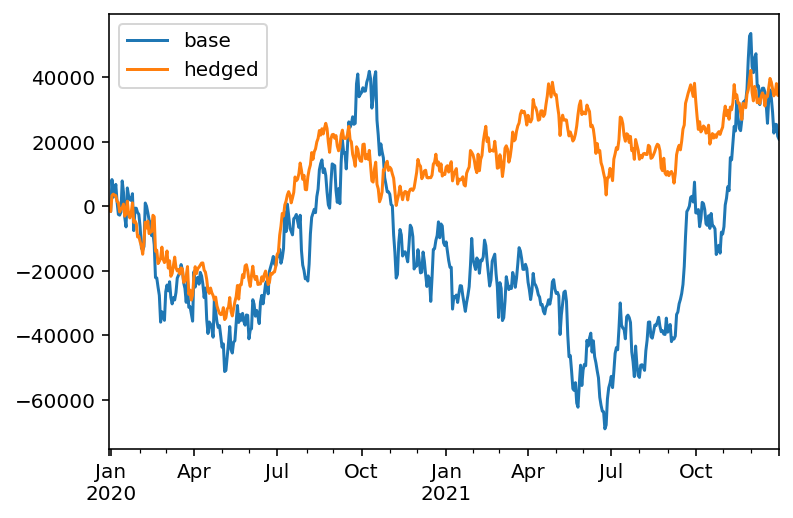

In [10]:
# Total PNL time series values
pd.DataFrame( {'base':base_test.strategy.values, 'hedged':hedge_test.strategy.values} ).plot()

<AxesSubplot:>

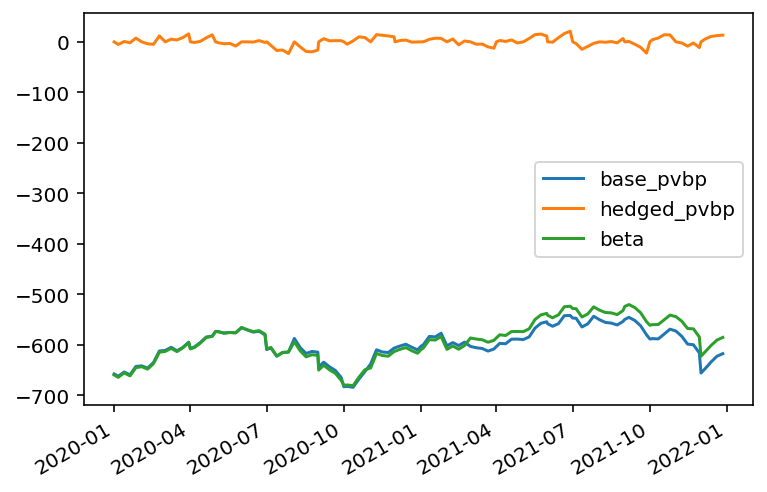

In [11]:
# Total risk time series values
pd.DataFrame( {'base_pvbp':base_test.strategy.risks['pvbp'], 
               'hedged_pvbp':hedge_test.strategy.risks['pvbp'],
               'beta':hedge_test.strategy.risks['beta']} ).dropna().plot()

<AxesSubplot:>

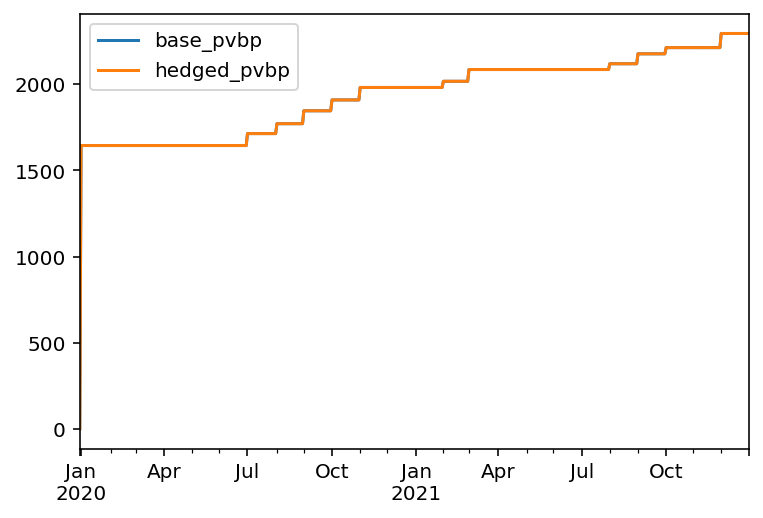

In [12]:
# Total bid/offer paid (same for both strategies)
pd.DataFrame( {'base_pvbp':base_test.strategy.bidoffers_paid, 
               'hedged_pvbp':hedge_test.strategy.bidoffers_paid }).cumsum().dropna().plot()

## Example 2: Nested Strategies

In [13]:
# Set up a more complex strategy and a backtest

# The goal of the more complex strategy is to define two sub-strategies of corporate bonds
# - Highest yield bonds
# - Lowest yield bonds
# Then we will go long the high yield bonds, short the low yield bonds in equal weight
# Lastly we will hedge the rates risk with the government bond

govt_securities = [ bt.CouponPayingHedgeSecurity( name ) for name in govt_data.index]
corp_securities = [ bt.CouponPayingSecurity( name ) for name in corp_data.index ]

def get_algos( n, sort_descending ):
    ''' Helper function to return the algos for long or short portfolio, based on top n yields'''
    return [
        # Close any matured bond positions
        bt.algos.ClosePositionsAfterDates( 'corp_maturity' ),
        # Specify how frequenty to rebalance 
        bt.algos.RunMonthly(),                     
        # Select instruments for rebalancing. Start with everything
        bt.algos.SelectAll(),        
        # Prevent matured/rolled instruments from coming back into the mix
        bt.algos.SelectActive(), 
        # Set the stat to be used for selection
        bt.algos.SetStat( 'corp_yield' ),
        # Select the top N yielding bonds
        bt.algos.SelectN( n, sort_descending, filter_selected=True ),
        # Specify how to weigh the securities
        bt.algos.WeighEqually(),
        bt.algos.ScaleWeights(1. if sort_descending else -1.), # Determine long/short
        # Set the target portfolio size
        bt.algos.SetNotional( 'notional_value' ), 
        # Rebalance the portfolio
        bt.algos.Rebalance(),     
    ]
bottom_algos = []
top_strategy = bt.FixedIncomeStrategy('TopStrategy', get_algos( 10, True ), children = corp_securities)
bottom_strategy = bt.FixedIncomeStrategy('BottomStrategy',get_algos( 10, False ), children = corp_securities)

risk_stack = bt.AlgoStack(
    # Specify how frequently to calculate risk
    bt.algos.Or( [bt.algos.RunWeekly(), 
                  bt.algos.RunMonthly()] ),
    # Update the risk given any positions that have been put on so far in the current step
    bt.algos.UpdateRisk( 'pvbp', history=2),
    bt.algos.UpdateRisk( 'beta', history=2),  
)
hedging_stack = bt.AlgoStack(
    # Close any matured hedge positions (including hedges)
    bt.algos.ClosePositionsAfterDates( 'govt_maturity' ),
    # Roll government bond positions into the On The Run
    bt.algos.RollPositionsAfterDates( 'govt_roll_map' ),
    # Specify how frequently to hedge risk
    bt.algos.RunMonthly(),     
    # Select the "alias" for the on-the-run government bond...
    bt.algos.SelectThese( [series_name], include_no_data = True ),
    # ... and then resolve it to the underlying security for the given date
    bt.algos.ResolveOnTheRun( 'govt_otr' ),    
    # Hedge out the pvbp risk using the selected government bond
    bt.algos.HedgeRisks( ['pvbp']),
    # Need to update risk again after hedging so that it gets recorded correctly (post-hedges)
    bt.algos.UpdateRisk( 'pvbp', history=2),        
)
debug_stack = bt.core.AlgoStack(
    # Specify how frequently to display debug info
    bt.algos.RunMonthly(),  
    bt.algos.PrintInfo('{now}: End   {name}\tNotional:  {_notl_value:0.0f},\t Value: {_value:0.0f},\t Price: {_price:0.4f}'),    
    bt.algos.PrintRisk('Risk: \tPVBP: {pvbp:0.0f},\t Beta: {beta:0.0f}'),
)
trading_stack =bt.core.AlgoStack(    
    # Specify how frequently to rebalance the portfolio of sub-strategies
    bt.algos.RunOnce(),     
    # Specify how to weigh the sub-strategies
    bt.algos.WeighSpecified( TopStrategy=0.5, BottomStrategy=-0.5),
    # Rebalance the portfolio
    bt.algos.Rebalance()
)
        
children = [ top_strategy, bottom_strategy ] + govt_securities
base_strategy = bt.FixedIncomeStrategy('BaseStrategy', [ bt.algos.Or( [trading_stack, risk_stack, debug_stack ] ) ], children = children)
hedged_strategy = bt.FixedIncomeStrategy('HedgedStrategy', [ bt.algos.Or( [trading_stack, risk_stack, hedging_stack, debug_stack ] ) ], children = children)

# Here we use clean prices as the data and accrued as the coupon. Could alternatively use dirty prices and cashflows.
data = pd.concat( [ govt_price, corp_price ], axis=1) / 100.  # Because we need prices per unit notional
additional_data = { 'coupons' : pd.concat([govt_accrued, corp_accrued], axis=1) / 100., # Because we need coupons per unit notional                    
                   'notional_value' : pd.Series( data=1e6, index=data.index ),
                   'govt_maturity' : govt_data.rename(columns={"mat_date": "date"}),
                   'corp_maturity' : corp_data.rename(columns={"mat_date": "date"}),
                   'govt_roll_map' : govt_roll_map,
                   'govt_otr' : govt_otr,
                   'corp_yield' : corp_yield,
                   'unit_risk' : {'pvbp' : pd.concat( [ govt_pvbp, corp_pvbp] ,axis=1)/100.,
                                  'beta' : corp_betas * corp_pvbp / 100.},
                  }
base_test = bt.Backtest( base_strategy, data, 'BaseBacktest', 
                initial_capital = 0,
                additional_data = additional_data)
hedge_test = bt.Backtest( hedged_strategy, data, 'HedgedBacktest', 
                initial_capital = 0,
                additional_data = additional_data)
out = bt.run( base_test, hedge_test )

2020-01-01 00:00:00: End   BaseStrategy	Notional:  0,	 Value: 0,	 Price: 100.0000
Risk: 	PVBP: 0,	 Beta: 0
2020-02-03 00:00:00: End   BaseStrategy	Notional:  2000000,	 Value: 3277,	 Price: 100.1639
Risk: 	PVBP: 51,	 Beta: 41
2020-03-02 00:00:00: End   BaseStrategy	Notional:  2000000,	 Value: 7297,	 Price: 100.3649
Risk: 	PVBP: 45,	 Beta: 34
2020-04-01 00:00:00: End   BaseStrategy	Notional:  2000000,	 Value: 9336,	 Price: 100.4668
Risk: 	PVBP: 44,	 Beta: 34
2020-05-01 00:00:00: End   BaseStrategy	Notional:  2000000,	 Value: 13453,	 Price: 100.6727
Risk: 	PVBP: 38,	 Beta: 28
2020-06-01 00:00:00: End   BaseStrategy	Notional:  2000000,	 Value: 15887,	 Price: 100.7943
Risk: 	PVBP: 37,	 Beta: 26
2020-07-01 00:00:00: End   BaseStrategy	Notional:  1800000,	 Value: 16024,	 Price: 100.8010
Risk: 	PVBP: 39,	 Beta: 28
2020-08-03 00:00:00: End   BaseStrategy	Notional:  2000000,	 Value: 14785,	 Price: 100.7391
Risk: 	PVBP: -152,	 Beta: -124
2020-09-01 00:00:00: End   BaseStrategy	Notional:  1800000,

<AxesSubplot:>

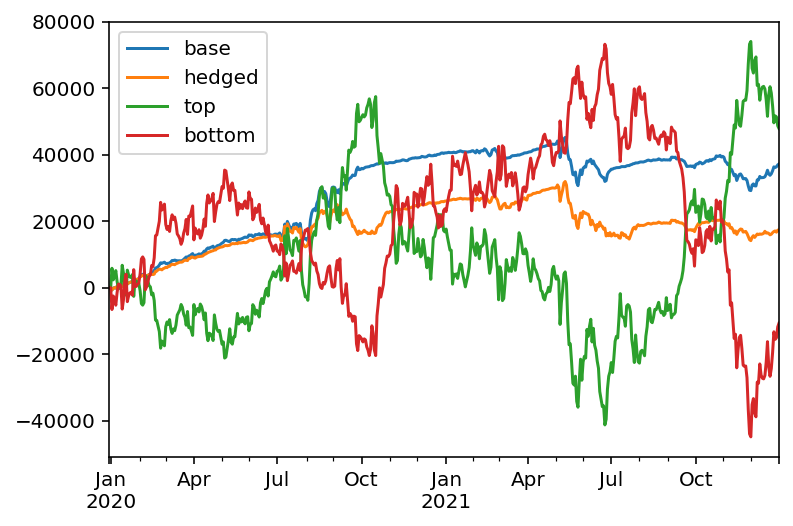

In [14]:
# Total PNL time series values
pd.DataFrame( {'base':base_test.strategy.values, 
               'hedged':hedge_test.strategy.values,
               'top':base_test.strategy['TopStrategy'].values,
               'bottom':base_test.strategy['BottomStrategy'].values}
            ).plot()

<AxesSubplot:>

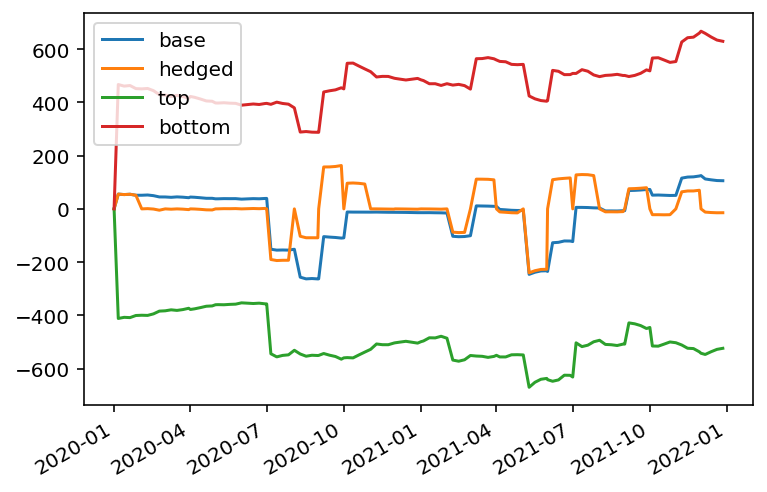

In [15]:
# Total pvbp time series values
pd.DataFrame( {'base':base_test.strategy.risks['pvbp'], 
               'hedged':hedge_test.strategy.risks['pvbp'],
               'top':base_test.strategy['TopStrategy'].risks['pvbp'],
               'bottom':base_test.strategy['BottomStrategy'].risks['pvbp']} 
            ).dropna().plot()

<AxesSubplot:>

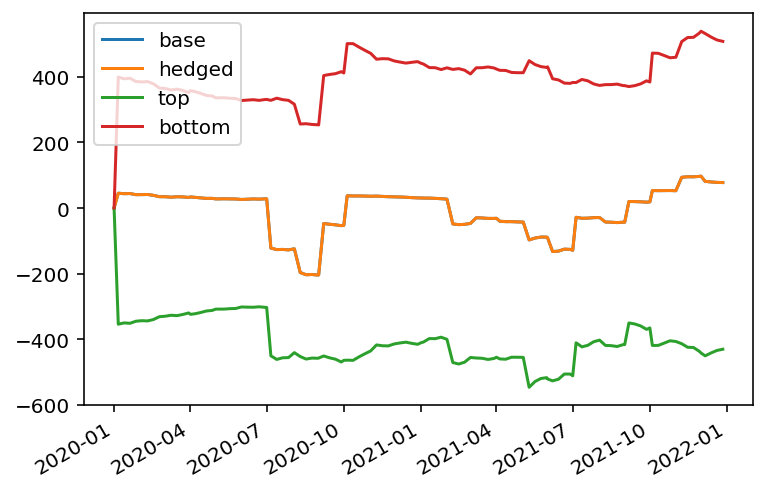

In [16]:
# Total beta time series values
pd.DataFrame( {'base':base_test.strategy.risks['beta'], 
               'hedged':hedge_test.strategy.risks['beta'],
               'top':base_test.strategy['TopStrategy'].risks['beta'],
               'bottom':base_test.strategy['BottomStrategy'].risks['beta']} 
            ).dropna().plot()

<AxesSubplot:>

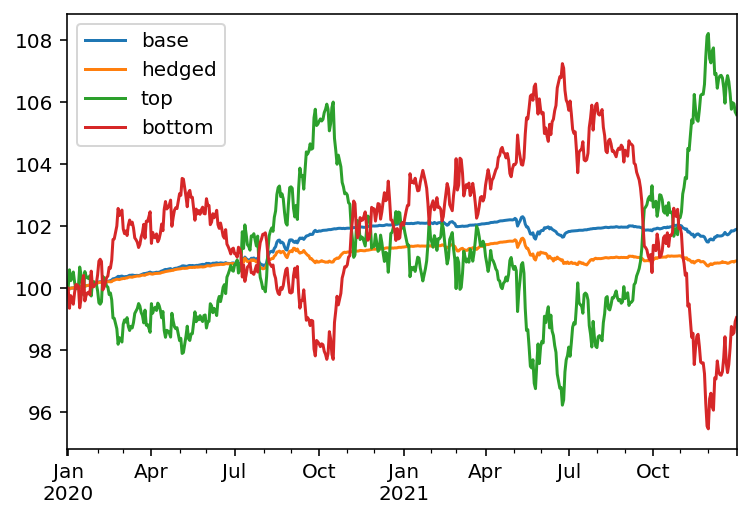

In [17]:
# "Price" time series values
pd.DataFrame( {'base':base_test.strategy.prices, 
               'hedged':hedge_test.strategy.prices,
               'top':base_test.strategy['TopStrategy'].prices,
               'bottom':base_test.strategy['BottomStrategy'].prices}
            ).plot()

In [18]:
# Show transactions
out.get_transactions('HedgedBacktest').head(20)

price  quantity
Date       Security                    
2020-01-01 corp0000  1.009697 -100000.0
           corp0001  0.991417  100000.0
           corp0002  1.016553 -100000.0
           corp0005  1.035779 -100000.0
           corp0009  1.014195  100000.0
           corp0015  0.849097  100000.0
           corp0017  1.018107 -100000.0
           corp0018  1.009549  100000.0
           corp0019  0.908531  100000.0
           corp0023  1.216847  100000.0
           corp0024  1.094375 -100000.0
           corp0025  1.054762 -100000.0
           corp0030  0.888091  100000.0
           corp0032  1.086487 -100000.0
           corp0035  0.996676  100000.0
           corp0036  1.070212 -100000.0
           corp0037  0.992530  100000.0
           corp0044  0.959150  100000.0
           corp0048  0.987408 -100000.0
           corp0049  1.016879 -100000.0